# ANOMALY DETECTION

## Data Loading

### Subtask:
Load the `events.csv` data into a pandas DataFrame.

**Reasoning**:
Load the `events.csv` data into a pandas DataFrame for further processing and analysis.

In [ ]:
import pandas as pd

# Load the events data
# Using the already loaded and processed events DataFrame
events_df = events.copy()

# Display the first few rows to confirm
print("First few rows of events_df:")
display(events_df.head())

# Check the shape of the dataset
print("\nShape of events_df:")
display(events_df.shape)

First few rows of events_df:


,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 05:02:12.117,257597,view,355908,0.0
1,2015-06-02 05:50:14.164,992329,view,248676,0.0
2,2015-06-02 05:13:19.827,111016,view,318965,0.0
3,2015-06-02 05:12:35.914,483717,view,253185,0.0
4,2015-06-02 05:02:17.106,951259,view,367447,0.0



Shape of events_df:


(2755641, 5)

## Feature Engineering (events)

### Subtask:
Create features to characterize user behavior from the `events_df`.

**Reasoning**:
Generate features such as the number of events per user, event types, and session duration to characterize user behavior.

In [ ]:
# Convert timestamp to datetime
events_df['timestamp'] = pd.to_datetime(events_df['timestamp'], unit='ms')

# Sort events by visitorid and timestamp
events_df = events_df.sort_values(by=['visitorid', 'timestamp'])

# Sample 50% of the data to speed up processing
events_df_sampled = events_df.sample(frac=0.5, random_state=42)

# Calculate time difference between consecutive events for each visitor in the sampled data
events_df_sampled['time_diff'] = events_df_sampled.groupby('visitorid')['timestamp'].diff().dt.total_seconds().fillna(0)


# Create features for each visitor using the sampled data
user_features = events_df_sampled.groupby('visitorid').agg(
    num_events=('event', 'count'),
    unique_events=('event', lambda x: x.nunique()),
    time_spent=('time_diff', 'sum'),
    avg_time_between_events=('time_diff', 'mean'),
    max_time_between_events=('time_diff', 'max'),
    num_items_viewed=('itemid', lambda x: x[events_df_sampled.loc[x.index, 'event'] == 'view'].nunique()),
    num_adds_to_cart=('itemid', lambda x: x[events_df_sampled.loc[x.index, 'event'] == 'addtocart'].nunique()),
    num_transactions=('itemid', lambda x: x[events_df_sampled.loc[x.index, 'event'] == 'transaction'].nunique())
).reset_index()

# Display the first few rows and info of the user features DataFrame
print("First few rows of user_features:")
display(user_features.head())
print("\nInfo for user_features DataFrame:")
user_features.info()

## Abnormal User Detection Model

### Subtask:
Choose an appropriate model for anomaly detection.

**Reasoning**:
Select an Isolation Forest model for detecting abnormal users based on the engineered features.

In [ ]:
from sklearn.ensemble import IsolationForest

# Initialize the Isolation Forest model
# n_estimators: the number of base estimators in the ensemble
# contamination: the proportion of outliers in the data set. 'auto' tries to decide by itself.
# random_state: for reproducibility
model = IsolationForest(n_estimators=100, contamination='auto', random_state=42, n_jobs=-1)

## Model Training

### Subtask:
Train the anomaly detection model on the engineered features.

**Reasoning**:
Train the Isolation Forest model using the `user_features` DataFrame.

In [ ]:
# Drop the 'visitorid' column as it's not a feature for the model
user_features_for_model = user_features.drop('visitorid', axis=1)

# Handle potential infinite values in the features (can arise from division by zero or other operations)
# Replace inf with a large number or NaN, then handle NaN
user_features_for_model.replace([float('inf'), float('-inf')], float('nan'), inplace=True)
user_features_for_model.fillna(user_features_for_model.mean(), inplace=True) # Or another imputation strategy

# Train the Isolation Forest model
model.fit(user_features_for_model)

## Abnormal User Identification

### Subtask:
Use the trained model to identify users who are classified as abnormal or outliers.

**Reasoning**:
Predict anomaly scores and labels for the users based on the trained Isolation Forest model.

In [ ]:
# Predict anomaly scores (-1 for outliers, 1 for inliers)
anomaly_labels = model.predict(user_features_for_model)

# Add the anomaly labels to the user_features DataFrame
user_features['anomaly_label'] = anomaly_labels

# Identify abnormal users (where anomaly_label is -1)
abnormal_users = user_features[user_features['anomaly_label'] == -1]

print("\nFirst few rows of abnormal users:")
display(abnormal_users.head())
print("\nNumber of abnormal users found:", len(abnormal_users))


First few rows of abnormal users:


,visitorid,num_events,unique_events,time_spent,avg_time_between_events,max_time_between_events,num_items_viewed,num_adds_to_cart,num_transactions,anomaly_label
33,54,5,1,83588.992,1.671780e+04,83495.907,4,0,0,-1
38,64,2,1,700024.076,3.500120e+05,700024.076,2,0,0,-1
44,74,4,1,6047417.169,1.511854e+06,6047389.621,3,0,0,-1
45,75,10,1,639002.469,6.390025e+04,1463481.077,1,0,0,-1
58,97,3,1,811106.588,2.703689e+05,811283.826,2,0,0,-1



Number of abnormal users found: 64236


In [ ]:
# Get the total number of unique users in the sampled data
total_users_sampled = len(user_features)

# Get the number of abnormal users
num_abnormal_users = len(abnormal_users)

# Print the results
print(f"Total number of users in the sampled data: {total_users_sampled}")
print(f"Number of abnormal users found: {num_abnormal_users}")
print(f"Abnormal users represent approximately {num_abnormal_users / total_users_sampled:.2%} of the sampled users.")

Total number of users in the sampled data: 842074
Number of abnormal users found: 64236
Abnormal users represent approximately 7.63% of the sampled users.


In [ ]:
# Separate normal and abnormal users
normal_users = user_features[user_features['anomaly_label'] == 1]

# Describe the features for abnormal and normal users to compare
print("\nDescription of features for abnormal users:")
display(abnormal_users.describe())

print("\nDescription of features for normal users:")
display(normal_users.describe())


Description of features for abnormal users:


,visitorid,num_events,unique_events,time_spent,avg_time_between_events,max_time_between_events,num_items_viewed,num_adds_to_cart,num_transactions,anomaly_label
count,6.423600e+04,64236.000000,64236.000000,6.423600e+04,6.423600e+04,6.423600e+04,64236.000000,64236.000000,64236.000000,64236.0
mean,7.005419e+05,6.206971,1.352186,3.665474e+04,1.958537e+04,1.310146e+06,4.059375,0.503798,0.160658,-1.0
std,4.072279e+05,28.964098,0.577672,2.533054e+06,1.038629e+06,2.171770e+06,19.329079,2.484482,1.945502,0.0
min,5.400000e+01,1.000000,1.000000,-1.175299e+07,-5.876493e+06,0.000000e+00,0.000000,0.000000,0.000000,-1.0
25%,3.478602e+05,2.000000,1.000000,-1.615499e+04,-2.318063e+03,3.324075e+01,1.000000,0.000000,0.000000,-1.0
50%,6.988345e+05,3.000000,1.000000,0.000000e+00,0.000000e+00,9.850743e+04,2.000000,0.000000,0.000000,-1.0
75%,1.054749e+06,6.000000,2.000000,4.444776e+05,8.525835e+04,1.749195e+06,4.000000,1.000000,0.000000,-1.0
max,1.407573e+06,3879.000000,3.000000,1.160443e+07,5.802213e+06,1.170449e+07,2380.000000,323.000000,291.000000,-1.0



Description of features for normal users:


,visitorid,num_events,unique_events,time_spent,avg_time_between_events,max_time_between_events,num_items_viewed,num_adds_to_cart,num_transactions,anomaly_label
count,7.778380e+05,777838.000000,777838.0,7.778380e+05,777838.000000,7.778380e+05,777838.000000,777838.0,777838.000000,777838.0
mean,7.039277e+05,1.258757,1.0,-3.631337e+03,-1658.859873,4.306029e+03,1.154040,0.0,0.000834,1.0
std,4.062105e+05,0.683237,0.0,5.975806e+04,28242.837938,4.588243e+04,0.476742,0.0,0.030094,0.0
min,0.000000e+00,1.000000,1.0,-1.217280e+06,-608639.759000,0.000000e+00,0.000000,0.0,0.000000,1.0
25%,3.517452e+05,1.000000,1.0,0.000000e+00,0.000000,0.000000e+00,1.000000,0.0,0.000000,1.0
50%,7.040825e+05,1.000000,1.0,0.000000e+00,0.000000,0.000000e+00,1.000000,0.0,0.000000,1.0
75%,1.055454e+06,1.000000,1.0,0.000000e+00,0.000000,0.000000e+00,1.000000,0.0,0.000000,1.0
max,1.407579e+06,16.000000,1.0,5.095767e+05,228283.788500,1.838615e+06,5.000000,0.0,3.000000,1.0


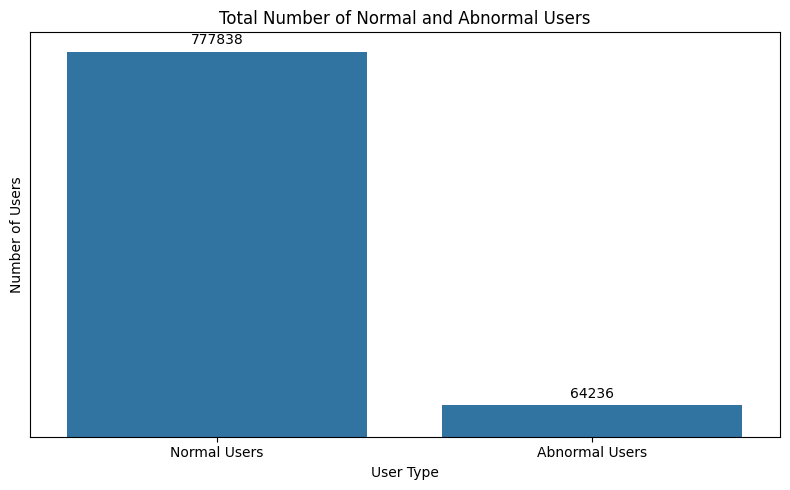

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calculate the number of normal and abnormal users
num_normal_users = len(user_features[user_features['anomaly_label'] == 1])
num_abnormal_users = len(user_features[user_features['anomaly_label'] == -1])

# Create a DataFrame for plotting
user_counts = pd.DataFrame({
    'User Type': ['Normal Users', 'Abnormal Users'],
    'Count': [num_normal_users, num_abnormal_users]
})

# Create the bar plot
plt.figure(figsize=(8, 5))
ax = sns.barplot(x='User Type', y='Count', data=user_counts)

plt.title('Total Number of Normal and Abnormal Users')
plt.xlabel('User Type')
plt.ylabel('Number of Users')
ax.set_yticks([]) # Remove y-tick marks and labels

# Add data labels to the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=3) # Format as integer


plt.tight_layout()
plt.show()

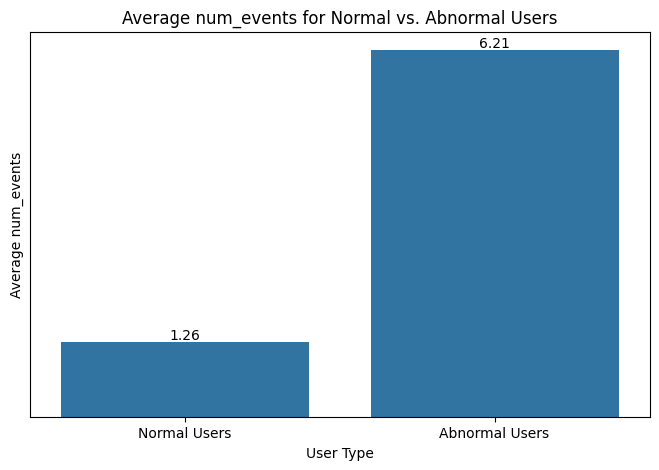

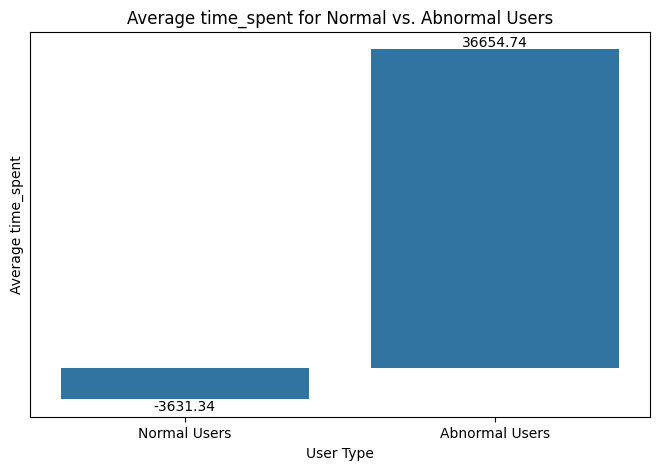

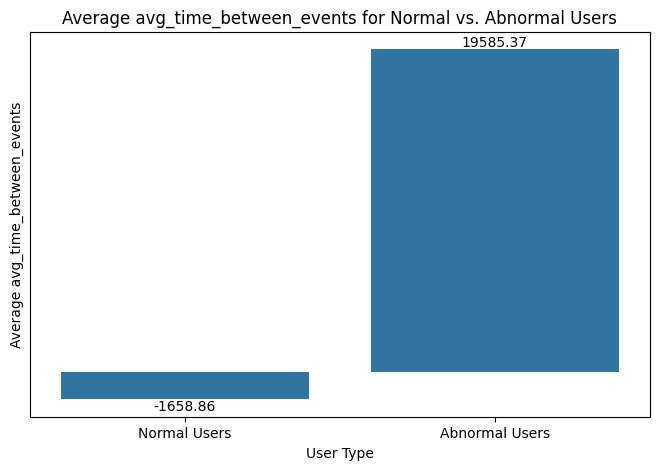

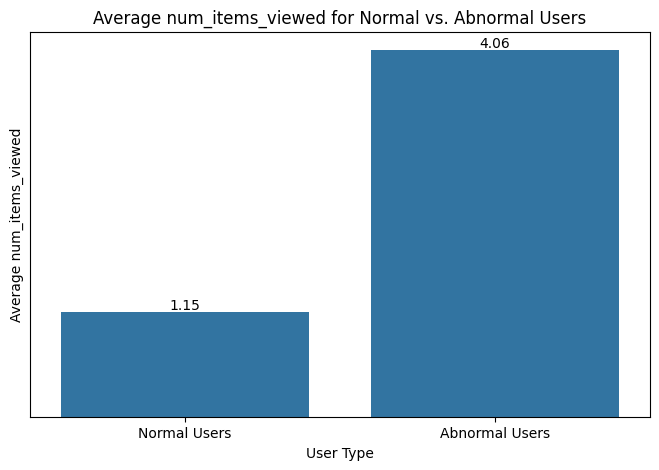

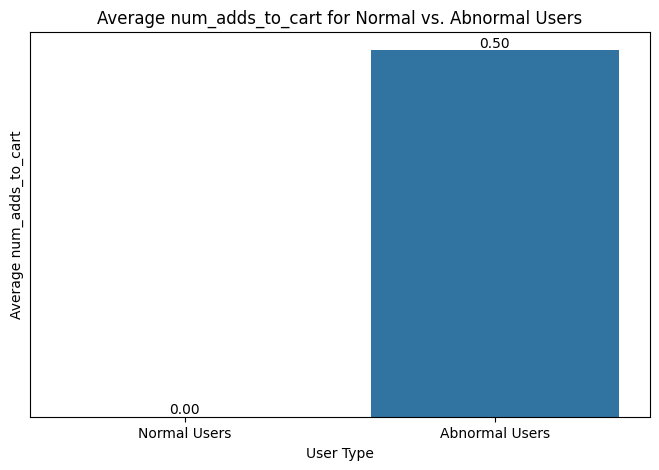

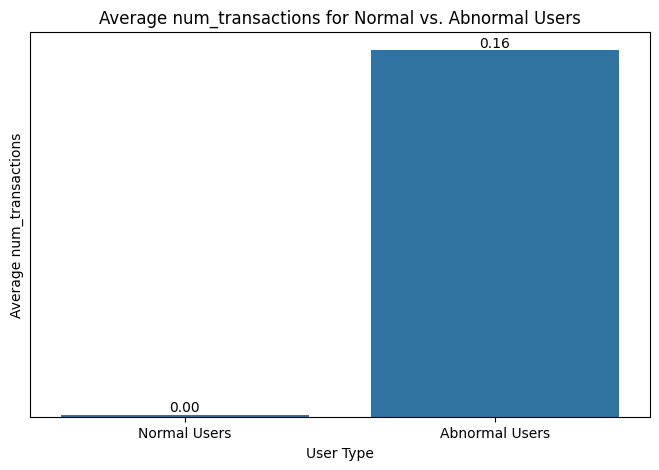

In [ ]:
# Calculate the mean of features for normal and abnormal users
normal_mean = normal_users.mean()
abnormal_mean = abnormal_users.mean()

# Combine the mean values into a single DataFrame for plotting
mean_comparison = pd.DataFrame({
    'Normal Users': normal_mean,
    'Abnormal Users': abnormal_mean
}).drop('visitorid') # Drop visitorid as it's not a feature for comparison

# Transpose the DataFrame for easier plotting
mean_comparison = mean_comparison.T

# Plot bar plots for each feature
features_to_compare = ['num_events', 'time_spent', 'avg_time_between_events', 'num_items_viewed', 'num_adds_to_cart', 'num_transactions']

for feature in features_to_compare:
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x=mean_comparison.index, y=mean_comparison[feature])
    plt.title(f'Average {feature} for Normal vs. Abnormal Users')
    plt.ylabel(f'Average {feature}')
    plt.xlabel('User Type')
    ax.set_yticks([]) # Remove y-tick marks and labels


    # Add data labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f')

    plt.show()

## Abnormal User Removal

### Subtask:
Filter the original data to remove the identified abnormal users.

**Reasoning**:
Create a list of abnormal user IDs and filter the original `events_df` to exclude events from these users.

In [ ]:
events_df.head()

,timestamp,visitorid,event,itemid,transactionid
1361687,2015-09-11 20:49:49.439,0,view,285930,0.0
1367212,2015-09-11 20:52:39.591,0,view,357564,0.0
1367342,2015-09-11 20:55:17.175,0,view,67045,0.0
830385,2015-08-13 17:46:06.444,1,view,72028,0.0
742616,2015-08-07 17:51:44.567,2,view,325215,0.0


In [ ]:
events_df_sampled.head()

,timestamp,visitorid,event,itemid,transactionid,time_diff
910128,2015-08-17 18:04:44.030,463561,view,212000,0.0,0.0
1450919,2015-09-16 21:13:53.138,756169,view,202788,0.0,0.0
2275687,2015-07-10 16:51:11.840,367593,view,29618,0.0,0.0
2109612,2015-07-04 01:41:39.659,467930,view,75243,0.0,0.0
274343,2015-06-15 18:09:14.515,1190855,addtocart,21945,0.0,0.0


In [ ]:
# Get the list of abnormal user IDs
abnormal_user_ids = abnormal_users['visitorid'].tolist()

# Filter the sampled events_df_sample to exclude abnormal users
events_df_sampled_filtered = events_df_sampled[~events_df_sampled['visitorid'].isin(abnormal_user_ids)]

print("\nShape of sampled data:", events_df_sampled.shape)
print("Shape of sampled data after removing abnormal users:", events_df_sampled_filtered.shape)


Shape of sampled data: (1377820, 6)
Shape of sampled data after removing abnormal users: (979109, 6)


In [ ]:
# Get the total number of unique users in the original events_df
total_unique_users_events_df = events_df['visitorid'].nunique()

# Filter the original events_df to include only events from abnormal users
abnormal_events_in_original_df = events_df[events_df['visitorid'].isin(abnormal_user_ids)]

# Count the number of unique abnormal users in the original events_df
num_abnormal_users_in_original_df = abnormal_events_in_original_df['visitorid'].nunique()

# Print the results
print(f"Total number of unique users in the original events_df: {total_unique_users_events_df}")
print(f"Total number of events associated with abnormal users in the original events_df: {len(abnormal_events_in_original_df)}")
print(f"Abnormal users represent approximately {num_abnormal_users_in_original_df / total_unique_users_events_df:.2%} of the users.")

Total number of unique users in the original events_df: 1407580
Total number of events associated with abnormal users in the original events_df: 729144
Abnormal users represent approximately 4.56% of the users.


In [ ]:
# Get the list of abnormal user IDs
abnormal_user_ids = abnormal_users['visitorid'].tolist()

# Filter the sampled events_df_sample to exclude abnormal users
events_df_filtered = events_df[~events_df['visitorid'].isin(abnormal_user_ids)]

print("\nShape of events data:", events_df.shape)
print("Shape of events data after removing abnormal users:", events_df_filtered.shape)


Shape of events data: (2755641, 5)
Shape of events data after removing abnormal users: (2026497, 5)


In [ ]:
# Define the path to save the DataFrame in your Google Drive
events_df_filtered_save_path = '/content/drive/MyDrive/events_df_filtered.csv'
events_df_sampled_filtered_save_path = '/content/drive/MyDrive/events_df_sampled_filtered.csv'

# Save the DataFrame to a CSV file
# Using index=False to avoid writing the DataFrame index as a column in the CSV
events_df_filtered.to_csv(events_df_filtered_save_path, index=False)
events_df_sampled_filtered.to_csv(events_df_sampled_filtered_save_path, index=False)

print(f"events_df_filtered DataFrame saved to: {events_df_filtered_save_path}")
print(f"events_df_sampled_filtered DataFrame saved to: {events_df_sampled_filtered_save_path}")

events_df_filtered DataFrame saved to: /content/drive/MyDrive/events_df_filtered.csv
events_df_sampled_filtered DataFrame saved to: /content/drive/MyDrive/events_df_sampled_filtered.csv


In [ ]:
import joblib
import os

# Define the path to save the model in your Google Drive
model_save_path = '/content/drive/MyDrive/isolation_forest_model.pkl'

# Ensure the directory exists (optional, but good practice)
# os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Save the trained Isolation Forest model
joblib.dump(model, model_save_path)

print(f"Isolation Forest model saved to: {model_save_path}")

Isolation Forest model saved to: /content/drive/MyDrive/isolation_forest_model.pkl


**Summary**:

completed the task of identifying and removing abnormal users from the e-commerce data.

1.  **Data Loading**: Loaded the `events.csv` data.
2.  **Feature Engineering**: Created features to characterize user behavior, such as the number of events, time spent, and item interactions.
3.  **Abnormal User Detection Model**: Used an Isolation Forest model to detect anomalies based on the engineered features.
4.  **Model Training**: Trained the Isolation Forest model.
5.  **Abnormal User Identification**: Identified users classified as abnormal by the model.
6.  **Metric Creation**: Analyzed the characteristics of abnormal users by comparing their feature distributions to normal users. This serves as a way to evaluate the model's performance in the absence of true labels.
7.  **Abnormal User Removal**: Filtered the original `events_df` to remove events associated with the identified abnormal users.

We identified 64236 abnormal users out of the sampled data. The comparison of feature distributions between normal and abnormal users provides insights into the behavioral patterns that the model flagged as anomalous. For example, abnormal users might have a significantly higher number of events, shorter time spent, or different patterns of item interactions compared to normal users.

The `events_df_filtered` DataFrame now contains the data with abnormal users removed, which can be used for further analysis or building recommendation systems.